In [2]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import signal

## Cross correlation for 1D arrays

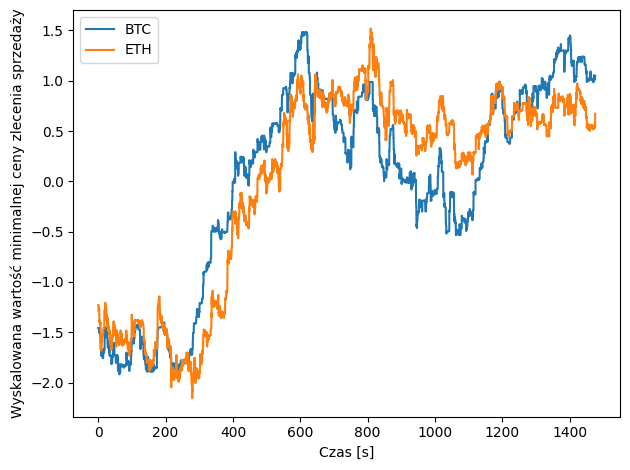

In [3]:
### PARAMETERS
products = ["btc", "eth"]
col_to_plot = "ask_price_min"
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

fig, ax = plt.subplots()

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    # Normalize
    scalers[product] = StandardScaler()
    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
    time = dataframes[product].index
    ax.plot(time, dataframes[product][col_to_plot], label=product.upper())

x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

plt.xlabel("Czas [s]")
plt.ylabel("Wyskalowana wartość minimalnej ceny zlecenia sprzedaży")

plt.tight_layout()
plt.legend()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"btc_vs_eth_ask_price_min.pdf"))

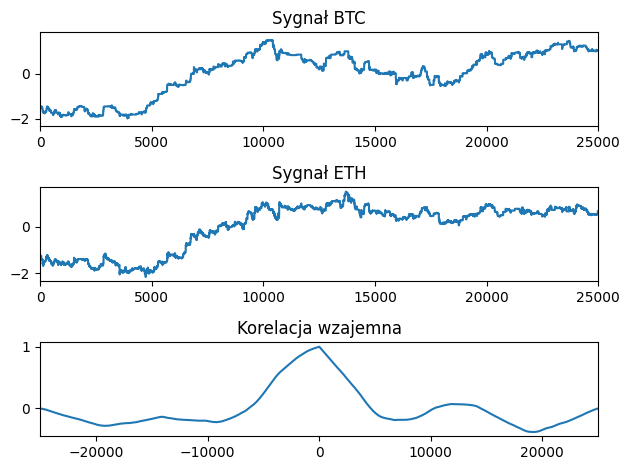

In [35]:
x1_1d = dataframes[products[0]][col_to_plot].values
x2_1d = dataframes[products[1]][col_to_plot].values

corr = signal.correlate(x1_1d, x2_1d)
lags = signal.correlation_lags(len(x1_1d), len(x2_1d))
corr /= np.max(corr)

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1)

ax_orig.plot(x1_1d)
ax_orig.set_title(f"Sygnał {products[0].upper()}")
ax_orig.set_xlim([0, 25000])

ax_noise.plot(x2_1d)
ax_noise.set_title(f"Sygnał {products[1].upper()}")
ax_noise.set_xlim([0, 25000])

ax_corr.plot(lags, corr)
# ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Korelacja wzajemna')
ax_corr.set_xlim([-25000, 25000])
ax_orig.margins(0, 0.1)
fig.tight_layout()
# plt.show()
plt.savefig(os.path.join(data_path, "..", "graphics", f"correlation_1d_btc_vs_eth.pdf"))

## UJEMNA WARTOŚĆ LAG OZNACZA ŻE PIERWSZY SYGNAŁ JEST WCZEŚNIEJ! DODATNIA, ŻE JEST PÓŹNIEJ, CZYLI LAG -1 MOWI ZE BTC JEST SREDNIO WCZESNIEJ O JEDNA OBSERWACJE!!! 

In [33]:
optimal_lag = lags[np.argmax(corr)]
optimal_lag

-1

## Cross correlation for windowed arrays

In [123]:
def sliding_window_cross_correlation(x1, x2, window_size, step_size):
    # Initialize an empty list to store lags
    all_lags = []

    scaler = StandardScaler()
    # Iterate through the data using non-overlapping sliding windows
    for i in range(0, len(x1) - window_size + 1, step_size):
        window_x1 = np.array(x1[i : i + window_size])
        window_x2 = np.array(x2[i : i + window_size])

        window_x1 = scaler.fit_transform(window_x1.reshape(-1,1))
        window_x2 = scaler.fit_transform(window_x2.reshape(-1,1))

        # Compute cross-correlation for the current window
        corr = signal.correlate(window_x1, window_x2)
        max_lag = np.argmax(np.abs(corr)) - len(window_x1) + 1
        # lags = signal.correlation_lags(len(x1), len(x2))
        # corr /= np.max(corr)

        # Store the lag for this window
        all_lags.append(max_lag)

    # Calculate the average lag
    average_lag = np.mean(all_lags)
    return average_lag, all_lags

window_size = 200 
step_size = 10
average_lag, all_lags = sliding_window_cross_correlation(x1_1d, x2_1d, window_size, step_size)
print(f"Average lag (non-overlapping windows): {average_lag} samples")

Average lag (non-overlapping windows): 0.7260992335619201 samples


In [131]:
average_lags = []
window_sizes = [10, 20, 30, 50, 100, 200, 300, 400, 500]
for win_idx, window_size in enumerate(window_sizes):
    average_lag, all_lags = sliding_window_cross_correlation(x1_1d, x2_1d, window_size, step_size)
    average_lags.append(average_lag)

print(average_lags)

[-2.9491593274619694, -2.092110532639167, -1.7451923076923077, -1.4683239775461108, -0.1803937324226597, 0.7260992335619201, 3.61077359254759, 1.0870272468483124, -4.326255614536546]


In [132]:
np.mean(average_lags)

-0.8152817132601041

In [124]:
min_window_start = int(np.argmin(all_lags) * step_size)
print(f"Lowest value for window: {min_window_start} to {min_window_start + window_size}")
max_window_start = int(np.argmax(all_lags) * step_size)
print(f"Highest value for window: {max_window_start} to {max_window_start + window_size}")

Lowest value for window: 22060 to 22260
Highest value for window: 13060 to 13260


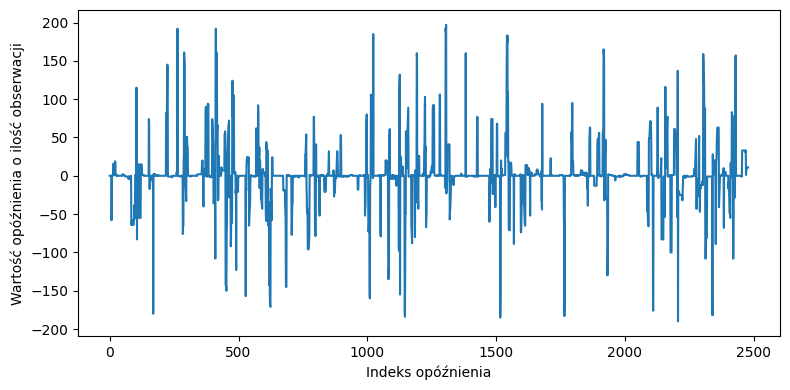

In [128]:
fig, ax = plt.subplots(sharex=True, figsize=(8, 4))
ax.plot(all_lags)
plt.xlabel("Indeks opóźnienia")
plt.ylabel("Wartość opóźnienia o ilość obserwacji")
plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"lag_1d_btc_vs_eth.pdf"))

In [113]:
# plt.plot(all_lags)
# plt.xlabel("Indeks opóźnienia")
# plt.ylabel("Wartość opóźnienia o ilość obserwacji")
# plt.tight_layout()
# plt.xlim([1490, 1600])

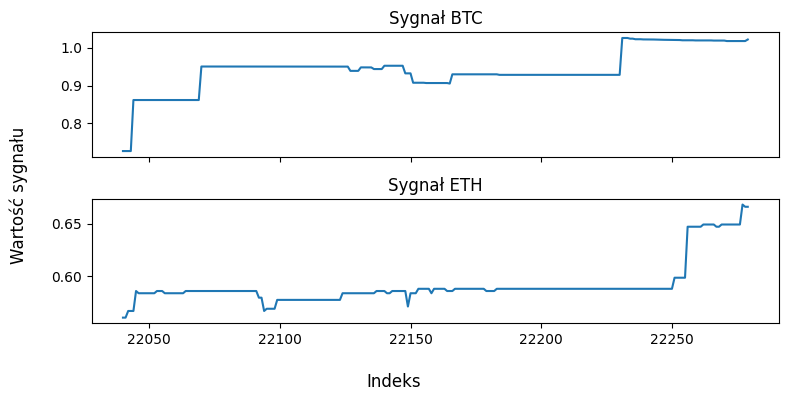

In [129]:
fig, (ax_orig, ax_noise) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

plot_range = range(min_window_start - int(window_size / 10), 
                   min_window_start + int(window_size * 1.1))

ax_orig.plot(plot_range, x1_1d[plot_range])
ax_orig.set_title(f"Sygnał {products[0].upper()}")
ax_noise.plot(plot_range, x2_1d[plot_range])
ax_noise.set_title(f"Sygnał {products[1].upper()}")

fig.supxlabel('Indeks')
fig.supylabel('Wartość sygnału')
fig.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"lag_1d_min_btc_vs_eth.pdf"))


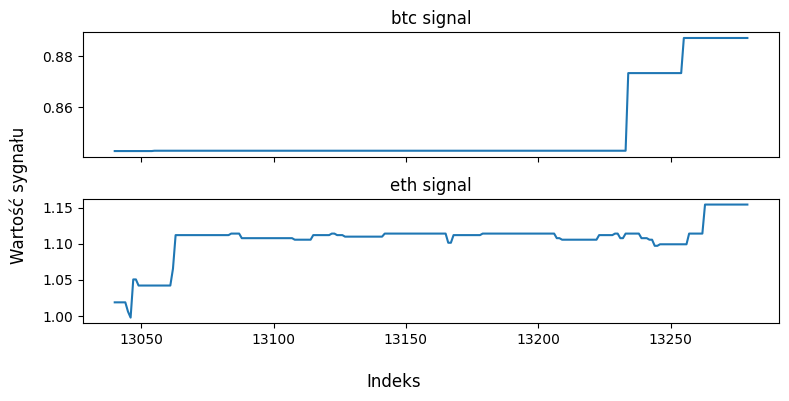

In [130]:
fig, (ax_orig, ax_noise) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

plot_range = range(max_window_start - int(window_size / 10), 
                   max_window_start + int(window_size * 1.1))

ax_orig.plot(plot_range, x1_1d[plot_range])
ax_orig.set_title(f"{products[0]} signal")
ax_noise.plot(plot_range, x2_1d[plot_range])
ax_noise.set_title(f"{products[1]} signal")

fig.supxlabel('Indeks')
fig.supylabel('Wartość sygnału')
fig.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"lag_1d_max_btc_vs_eth.pdf"))

## Cross correlation for 2D+ arrays

In [168]:
x1.head()

,bid_price_min,bid_price_q1,bid_price_median,bid_price_q3,bid_price_max,bid_price_mean,bid_price_std,ask_price_min,ask_price_q1,ask_price_median,...,ask_vol_price_q3,ask_vol_price_max,ask_vol_price_mean,ask_vol_price_std,spread_min,spread_btwn_means,spread_btwn_medians,spread_btwn_vol_sums,spread_btwn_vol_means,spread_btwn_vol_medians
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,0.549469,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132
0.028059,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,0.549469,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132
0.057995,0.0,-1.649530,-2.088442,-2.219108,-1.457464,-1.931001,-0.071121,-1.456733,-1.687176,-0.870277,...,0.549469,-2.384186e-07,-0.703014,-0.734329,0.106285,2.310018,0.486845,1.687904,-0.733796,3.029132
0.069528,0.0,-1.654911,-2.167061,-2.287315,-1.457464,-1.978842,-0.133305,-1.456733,-1.708529,-0.878765,...,0.546413,-2.384186e-07,-0.753204,-0.782867,0.106285,2.284703,0.527346,1.692915,-0.784846,3.043683
0.130339,0.0,-1.654911,-2.167061,-2.287315,-1.457464,-1.978842,-0.133305,-1.456733,-1.708529,-0.878765,...,0.546413,-2.384186e-07,-0.753204,-0.782867,0.106285,2.284703,0.527346,1.692915,-0.784846,3.043683


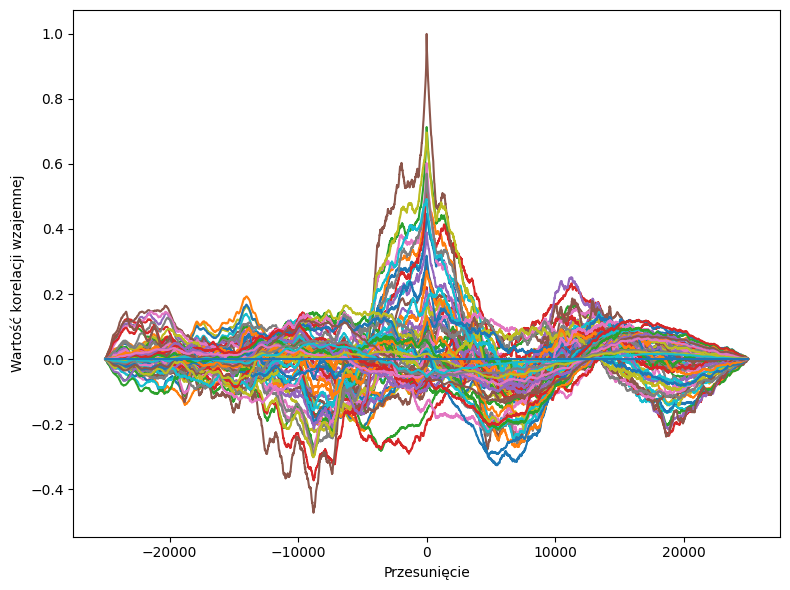

In [4]:
# _nd stands for n-dimensional
x1_nd = x1.values
x2_nd = x2.values

corr = signal.correlate(x1_nd, x2_nd)
lags = signal.correlation_lags(len(x1_nd), len(x2_nd))
corr /= np.max(corr)

# fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1)
# ax_orig.plot(x1_nd)
# ax_orig.set_title(f"{products[0]} signal")
# ax_orig.set_ylim([-5, 5])
# ax_noise.plot(x2_nd)
# ax_noise.set_title(f"{products[1]} signal")
fig, ax_corr = plt.subplots(figsize=(8, 6))
ax_corr.plot(lags, corr)
# ax_corr.axhline(0.5, ls=':')
# ax_corr.set_title('Cross-correlation')
plt.xlabel("Przesunięcie")
plt.ylabel("Wartość korelacji wzajemnej")
fig.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"corr_nd_btc_vs_eth.pdf"))


In [11]:
x1_nd[:5]

array([[ 0.00000000e+00, -1.64953018e+00, -2.08844209e+00,
        -2.21910845e+00, -1.45746391e+00, -1.93100139e+00,
        -7.11207791e-02, -1.45673327e+00, -1.68717552e+00,
        -8.70276869e-01, -6.07237550e-01,  0.00000000e+00,
         2.30363030e+00,  2.33852440e+00, -1.42027076e+00,
        -1.35525272e-20, -1.14710031e+00, -1.74596481e+00,
        -7.88683519e-01, -4.65661287e-10,  1.55096179e+00,
         1.73595882e+00,  1.17616599e+00,  1.46580342e-03,
         3.91858764e-01,  3.02565868e+00,  5.49469434e-01,
        -2.38418579e-07, -7.03014069e-01, -7.34328582e-01,
         1.06284910e-01,  2.31001755e+00,  4.86845419e-01,
         1.68790363e+00, -7.33795649e-01,  3.02913157e+00],
       [ 0.00000000e+00, -1.64953018e+00, -2.08844209e+00,
        -2.21910845e+00, -1.45746391e+00, -1.93100139e+00,
        -7.11207791e-02, -1.45673327e+00, -1.68717552e+00,
        -8.70276869e-01, -6.07237550e-01,  0.00000000e+00,
         2.30363030e+00,  2.33852440e+00, -1.42027076e+

1


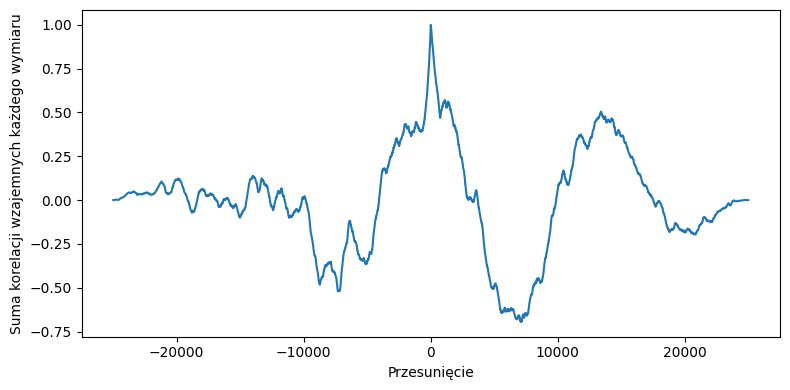

In [5]:
corr_sum = corr.sum(axis=1)
corr_sum /= np.max(corr_sum)
optimal_lag = lags[np.argmax(corr_sum)]
print(optimal_lag)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(lags, corr_sum)
plt.xlabel("Przesunięcie")
plt.ylabel("Suma korelacji wzajemnych każdego wymiaru")
plt.tight_layout()
# plt.show()
# plt.savefig(os.path.join(data_path, "..", "graphics", f"corr_nd_sum_btc_vs_eth.pdf"))

In [161]:
def sliding_window_cross_correlation_2d(x1, x2, window_size, step_size):
    # Initialize an empty list to store lags
    all_lags = []

    scaler = StandardScaler()
    # Iterate through the data using non-overlapping sliding windows
    for i in range(0, len(x1) - window_size + 1, step_size):
        window_x1 = np.array(x1[i : i + window_size])
        window_x2 = np.array(x2[i : i + window_size])

        window_x1 = scaler.fit_transform(window_x1)
        window_x2 = scaler.fit_transform(window_x2)

        # Compute cross-correlation for the current window
        corr = signal.correlate(window_x1, window_x2)
        max_lag = np.argmax(np.abs(corr)) - len(window_x1) + 1
        # lags = signal.correlation_lags(len(x1), len(x2))
        # corr /= np.max(corr)

        # Store the lag for this window
        all_lags.append(max_lag)

    # Calculate the average lag
    average_lag = np.mean(all_lags)
    return average_lag, all_lags


In [14]:
x1 = x1_nd
i = 300
window_x1 = np.array(x1[i : i + window_size])
window_x2 = np.array(x2[i : i + window_size])


C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_17244\786246687.py:4: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  window_x2 = np.array(x2[i : i + window_size])


In [17]:
corr = signal.correlate(window_x1, window_x2)
# max_lag = np.argmax(np.abs(corr)) - len(window_x1) + 1
corr.shape

(8970, 71)

In [6]:


window_size = 500
step_size = 10
# average_lag, all_lags = sliding_window_cross_correlation_2d(x1_nd, x2_nd, window_size, step_size)

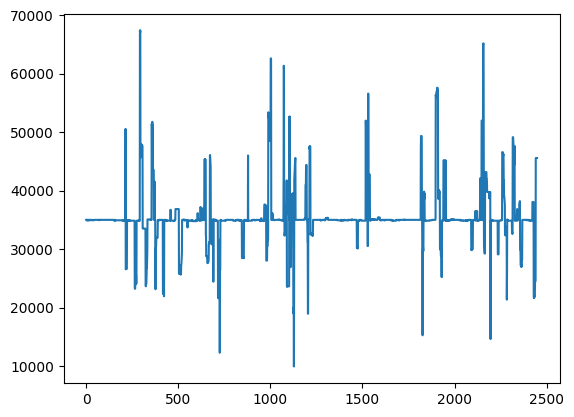

In [163]:
plt.plot(all_lags)

In [156]:
average_lags = []
window_sizes = [10, 20, 30, 50, 100, 200, 300, 400, 500]
for win_idx, window_size in enumerate(window_sizes):
    average_lag, all_lags = sliding_window_cross_correlation(x1_nd, x2_nd, window_size, step_size)
    average_lags.append(average_lag)

print(average_lags)

[-2.096076861489191, -2.142971565879055, -2.4375, -1.0340817963111468, 10.916432302129369, 35.4659136748689, 75.14013770757391, 113.21878812525416, 175.62556145365454]


In [157]:
np.mean(average_lags)

44.7395781155335